In [1]:
from collections import defaultdict

import numpy as np
import scipy as sp
import pandas as pd
from ipypb import track

from polara.evaluation import evaluation_engine as ee
from polara.evaluation.pipelines import random_grid, find_optimal_config

from lce import LCEModel, LCEModelItemColdStart
from data_preprocessing import (get_movielens_data,
                                get_bookcrossing_data,
                                get_similarity_data,
                                prepare_data_model,
                                prepare_cold_start_data_model)
from utils import (report_results, save_results,
                   apply_config, print_data_stats,
                   save_training_time, save_cv_training_time)

%matplotlib inline

In [2]:
seed = 42

In [3]:
experiment_name = 'lce'

# Experiment setup

In [4]:
data_labels = ['ML1M', 'ML10M', 'BX']

In [5]:
init_config = dict(seed = seed,
                   max_iterations = 75,
                   alpha = 0.1,
                   beta = 0.05,
                   max_neighbours=10,
                   )
lce_init_config = dict.fromkeys(data_labels, {'LCE': init_config,  # standard scenario
                                              'LCE(cs)': init_config})  # cold start

In [6]:
params = {
          'regularization': [1, 3, 10, 30],
          'rank': [40] # for initial tuning (exploration)
         }

In [7]:
coeffs = {
    'alpha': [0.1, 0.3, 0.5, 0.7, 0.9],
    'beta': [0, 0.05, 0.1, 0.3]
}

In [8]:
ranks_grid = [1, 15, 30, 50, 75, 100, 125, 150, 200, 250, 300, 400,
              500, 750, 1000, 1250, 1500, 2000, 2500, 3000]

In [9]:
lce_ranks = {'ML1M': [r for r in ranks_grid if r <= 1000],
             'ML10M': [r for r in ranks_grid if r <= 1000],
             'BX': [r for r in ranks_grid if r <= 2000]}

In [10]:
topk_values = [1, 3, 10, 20, 30]

In [11]:
target_metric = 'mrr'

In [12]:
data_dict = dict.fromkeys(data_labels)
meta_dict = dict.fromkeys(data_labels)
similarities = dict.fromkeys(data_labels)
sim_indices = dict.fromkeys(data_labels)

In [13]:
all_data = [data_dict, similarities, sim_indices, meta_dict]

## Movielens1M

In [14]:
lbl = 'ML1M'

In [15]:
data_dict[lbl], meta_dict[lbl] = get_movielens_data('../datasets/movielens/ml-1m.zip',
                                                    meta_path='data/meta_info_ml1m.csv',
                                                    implicit=True,
                                                    filter_no_meta=True)

In [16]:
# not used actually, simply to conform with general pipeline
itemid = meta_dict[lbl].index.name
sim_indices[lbl] = {itemid: meta_dict[lbl].index}
similarities[lbl] = {itemid: sp.sparse.eye(len(meta_dict[lbl].index))}

## Movielens10M

In [17]:
lbl = 'ML10M'

In [18]:
data_dict[lbl], meta_dict[lbl] = get_movielens_data('../datasets/movielens/ml-10m.zip',
                                                    meta_path='data/meta_info_ml10m.csv',
                                                    implicit=True,
                                                    filter_no_meta=True)

In [ ]:
# not used actually, simply to conform with general pipeline
itemid = meta_dict[lbl].index.name
sim_indices[lbl] = {itemid: meta_dict[lbl].index}
similarities[lbl] = {itemid: sp.sparse.eye(len(meta_dict[lbl].index))}

In [ ]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## BookCrossing

In [ ]:
lbl = 'BX'

In [ ]:
data_dict[lbl], meta_dict[lbl] = get_bookcrossing_data('../datasets/bookcrossing/BX-CSV-Dump.zip',
                                                       get_books_meta=True,
                                                       implicit=True,
                                                       pcore=5,
                                                       filter_no_meta=True)

In [ ]:
# not used actually, simply to conform with general pipeline
itemid = meta_dict[lbl].index.name
sim_indices[lbl] = {itemid: meta_dict[lbl].index}
similarities[lbl] = {itemid: sp.sparse.eye(len(meta_dict[lbl].index))}

In [ ]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Data stats

In [ ]:
print_data_stats(data_labels, all_data)

ML1M
{'userid': 6038, 'movieid': 3522}
density 2.699052132255699
similarity matrix density 0.028392958546280524
ML10M
{'userid': 69797, 'movieid': 10258}
density 0.6991397242349022
similarity matrix density 0.009748488984207448
BX
{'userid': 7160, 'isbn': 16273}
density 0.18925598044812894
similarity matrix density 0.0005841769822585451


# Standard experiment

In [ ]:
def prepare_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    lce = LCEModel(data_model, item_features=meta_dict[data_label])
    lce.method = 'LCE'
    models = [lce]
    apply_config(models, config, data_label)
    return models

def fine_tune_lce(model, params, label, ntrials=60, record_time_as=None):
    param_grid, param_names = random_grid(params, n=ntrials)
    best_lce_config, lce_scores = find_optimal_config(model, param_grid, param_names,
                                                      target_metric,
                                                      return_scores=True,
                                                      force_build=True,
                                                      iterator=lambda x: track(x, label=label))
    model_config = {model.method: dict(zip(param_names, best_lce_config))}
    model_scores = {model.method: lce_scores}
    try:
        if record_time_as:
            save_training_time(f'{experiment_name}_{record_time_as}', model, lce_scores.index, label)
    finally:
        return model_config, model_scores

## tuning

In [ ]:
config = {}
scores = {}
data_models = {}

In [ ]:
lce_init_config['ML1M']['LCE']

{'seed': 42,
 'max_iterations': 75,
 'alpha': 0.1,
 'beta': 0.05,
 'max_neighbours': 10}

### regularization

In [ ]:
_config = {}
_scores = {}
for label in track(data_labels):
    data_models[label] = prepare_data_model(label, *all_data, seed)
    model, = prepare_recommender_models(label, data_models, lce_init_config)
    _config[label], _ = fine_tune_lce(model, params, label)
del model

 [████████████████████████████████████████████████████████████] 3/3 [07:56<01:11, 158.83s/it]

           ML1M [█████████████████████████████████████████████] 4/4 [00:60<00:13, 14.92s/it]

          ML10M [█████████████████████████████████████████████] 4/4 [05:34<01:26, 83.59s/it]

             BX [█████████████████████████████████████████████] 4/4 [01:10<00:15, 17.59s/it]

In [ ]:
_config # will also reuse it in coldstart

{'ML1M': {'LCE': {'regularization': 30, 'rank': 40}},
 'ML10M': {'LCE': {'regularization': 30, 'rank': 40}},
 'BX': {'LCE': {'regularization': 10, 'rank': 40}}}

### $\alpha, \beta$

In [ ]:
for label in track(data_labels):
    data_models[label] = prepare_data_model(label, *all_data, seed)
    model, = prepare_recommender_models(label, data_models, [lce_init_config, _config])
    config[label], scores[label] = fine_tune_lce(model, coeffs, label, record_time_as='coeff')
    # make sure to save all parameters
    config[label][model.method].update(_config[label][model.method])
del model

 [████████████████████████████████████████████████████████████] 3/3 [36:14<06:16, 724.61s/it]

           ML1M [█████████████████████████████████████████████] 20/20 [05:02<00:21, 15.12s/it]

          ML10M [█████████████████████████████████████████████] 20/20 [24:45<01:25, 74.25s/it]

             BX [█████████████████████████████████████████████] 20/20 [06:15<00:16, 18.76s/it]

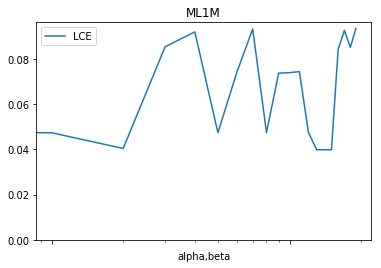

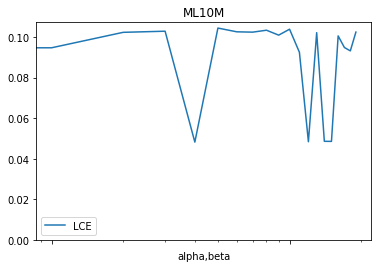

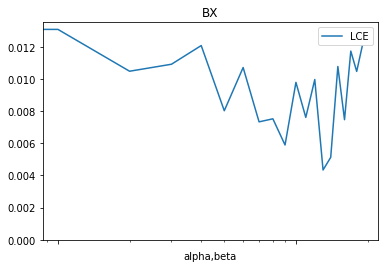

In [ ]:
report_results('tuning', scores);

In [ ]:
config

{'ML1M': {'LCE': {'alpha': 0.1,
   'beta': 0.1,
   'regularization': 30,
   'rank': 40}},
 'ML10M': {'LCE': {'alpha': 0.3,
   'beta': 0.1,
   'regularization': 30,
   'rank': 40}},
 'BX': {'LCE': {'alpha': 0.1, 'beta': 0.0, 'regularization': 10, 'rank': 40}}}

### saving data

In [ ]:
save_results(f'{experiment_name}_param', config=config, tuning=scores)

## rank estimation

In [ ]:
rank_config = {}
rank_scores = {}

In [ ]:
for label in track(data_labels):
    model, = prepare_recommender_models(label, data_models,
                                        [lce_init_config, config]) # initiate with optimal config
    rank_config[label], rank_scores[label] = fine_tune_lce(model, {'rank': lce_ranks[label]},
                                                          label, ntrials=0, record_time_as='rank')
del model

 [████████████████████████████████████████####################] 2/3 [02:15:26<01:54:26, 4062.98s/it]

           ML1M [█████████████████████████████████████████████] 15/15 [21:00<02:34, 84.03s/it]

          ML10M [█████████████████████████████████████████████] 15/15 [01:54:26<11:46, 457.70s/it]

             BX [███████████████████████████##################] 11/18 [20:57<00:18, 114.25s/it]

In [ ]:
report_results('rank', {lbl: v.sort_index() for lbl, scr in rank_scores.items() for k, v in scr.items()});

In [ ]:
rank_config

### saving data

In [ ]:
save_results(f'{experiment_name}_rank', config=rank_config, tuning=rank_scores)

## cross-validation

In [ ]:
result = {}
for label in track(data_labels):
    models = prepare_recommender_models(label, data_models, [lce_init_config, config, rank_config])
    result[label] = ee.run_cv_experiment(models,
                                         fold_experiment=ee.topk_test,
                                         topk_list=topk_values,
                                         ignore_feedback=True,
                                         iterator=lambda x: track(x, label=label))
    save_cv_training_time(experiment_name, models, label)

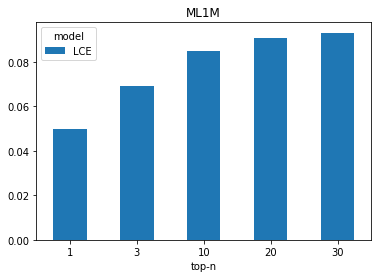

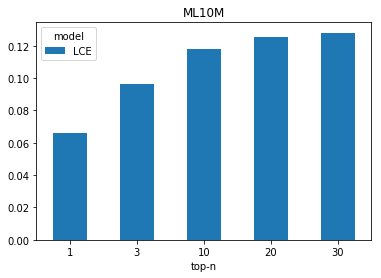

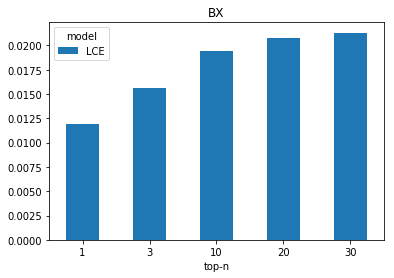

In [61]:
report_results('topn', result, target_metric);

In [62]:
pd.concat({lbl: res.mean(level='top-n').loc[10, :'ranking'] for lbl, res in result.items()}, axis=1)

,,BX,ML10M,ML1M
type,metric,,,
relevance,hr,0.043296,0.268563,0.187703
ranking,mrr,0.019476,0.118241,0.084784


### saving data

In [ ]:
save_results(experiment_name, cv=result)

# Cold start

In [ ]:
def prepare_cold_start_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    lce = LCEModelItemColdStart(data_model, item_features=meta_dict[data_label])
    lce.method = 'LCE(cs)'
    models = [lce]
    apply_config(models, config, data_label)
    return models

## tuning

In [ ]:
config_cold = {}
scores_cold = {}
data_models_cold = {}

In [ ]:
lce_init_config['ML1M']['LCE(cs)']

### $\alpha, \beta$

In [ ]:
_config_cold = {}
for label in track(data_labels):
    # reuse regularization param from standard scenario
    _config_cold[label] = {f'{k}(cs)' if k=='LCE' else k: v for k, v in _config[label].items()}
    data_models_cold[label] = prepare_cold_start_data_model(label, *all_data, seed)
    model, = prepare_cold_start_recommender_models(label, data_models_cold, [lce_init_config, _config_cold])
    config_cold[label], scores_cold[label] = fine_tune_lce(model, coeffs, label, record_time_as=None)
    # make sure to save all parameters
    config_cold[label][model.method].update(_config_cold[label][model.method])
del model

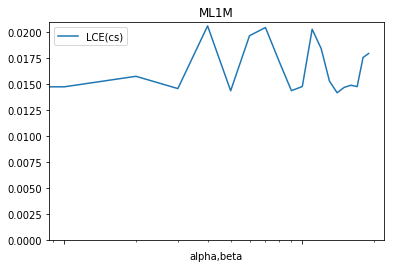

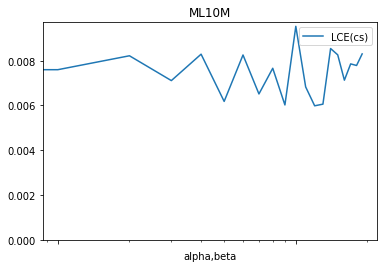

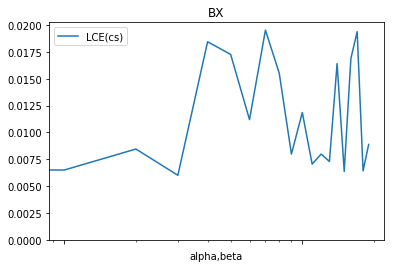

In [63]:
report_results('tuning', scores_cold);

In [64]:
config_cold

{'ML1M': {'LCE(cs)': {'alpha': 0.9,
   'beta': 0.0,
   'regularization': 30,
   'rank': 40}},
 'ML10M': {'LCE(cs)': {'alpha': 0.3,
   'beta': 0.0,
   'regularization': 30,
   'rank': 40}},
 'BX': {'LCE(cs)': {'alpha': 0.1,
   'beta': 0.0,
   'regularization': 10,
   'rank': 40}}}

### saving data

In [ ]:
save_results(f'{experiment_name}_coldstart_param', config=config_cold, tuning=scores_cold)

## rank estimation

In [ ]:
rank_config_cold = {}
rank_scores_cold = {}

In [ ]:
for label in track(data_labels):
    model, = prepare_cold_start_recommender_models(label, data_models_cold,
                                                   [lce_init_config, config_cold]) # initiate with optimal config
    rank_config_cold[label], rank_scores_cold[label] = fine_tune_lce(model, {'rank': lce_ranks[label]},
                                                                     label, ntrials=0)
del model

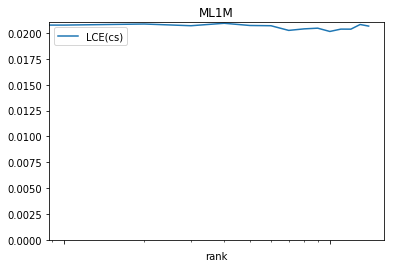

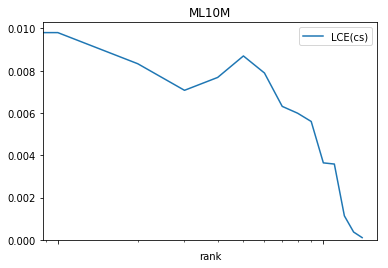

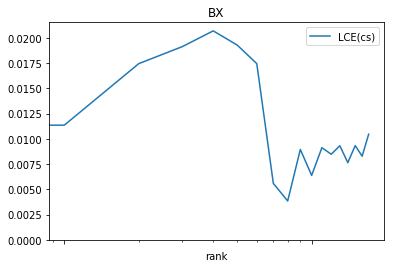

In [65]:
report_results('rank', {lbl: v.sort_index() for lbl, scr in rank_scores_cold.items() for k, v in scr.items()});

In [66]:
rank_config_cold

{'ML1M': {'LCE(cs)': {'rank': 1}},
 'ML10M': {'LCE(cs)': {'rank': 15}},
 'BX': {'LCE(cs)': {'rank': 75}}}

### saving data

In [ ]:
save_results(f'{experiment_name}_coldstart_rank', config=rank_config_cold, tuning=rank_scores_cold)

## cross validation

In [ ]:
result_cold = {}
for label in track(data_labels):
    models_cold = prepare_cold_start_recommender_models(label, data_models_cold,
                                                        [lce_init_config, config_cold, rank_config_cold])
    result_cold[label] = ee.run_cv_experiment(models_cold,
                                              fold_experiment=ee.topk_test,
                                              topk_list=topk_values,
                                              ignore_feedback=True,
                                              iterator=lambda x: track(x, label=label))

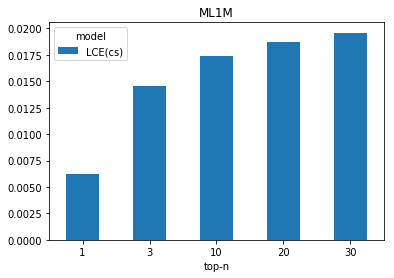

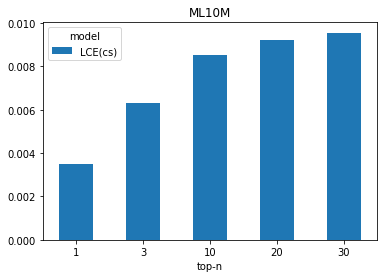

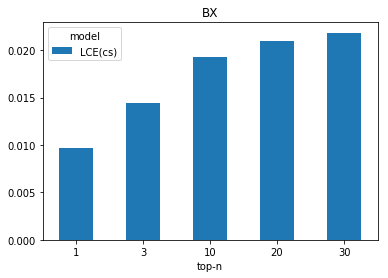

In [67]:
report_results('topn', result_cold, target_metric);

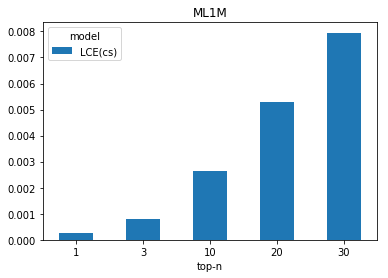

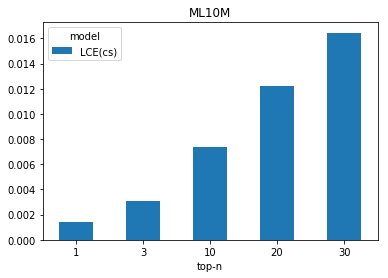

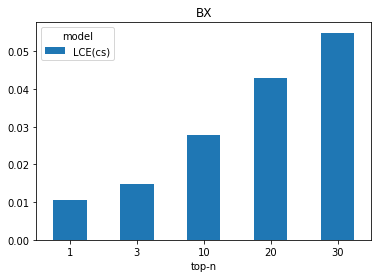

In [68]:
report_results('topn', result_cold, 'coverage');

### saving data

In [ ]:
save_results(f'{experiment_name}_coldstart', cv=result_cold)